In [1]:
import gc
import dill
import numpy as np
import pandas as pd
import axelrod as axl
from time import time
from pprint import pprint
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
pd.options.display.float_format = "{:,.2f}".format

# the following imports are from network / axl_utils folder
import network
from axl_utils import NNplayer, State, set_match, set_play

In [2]:
C = axl.Action.C
D = axl.Action.D

# config game rules
# doubled game length for some extra complexity
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

#### this stage will use axl.tournament function to train DQN play against multiple strategies
to see if it converges to TFT under more complex environment

## Set up environment & DQN

In [3]:
# import my modified tournament
# which ignores the interaction in last turn
from axl_utils.tournament import Tournament

In [4]:
tournament = Tournament([axl.Defector(), axl.Cooperator()], game=GAME, turns=GAME_LEN)
results = tournament.play()

Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 114.68it/s]


In [5]:
# example tournament result
# explanation of the elements can be found here: https://axelrod.readthedocs.io/en/stable/tutorials/advanced/tournament_results.html
summary = results.summarise()
headers = "Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate".split(',')
pd.DataFrame(map(list, summary), columns=headers)

# median score is based on normalized score, which represent the average return for each turn
# e.g. if 2 player cooperates the whole game, this should be 3.00 for both

# CC_to_C rate means the probability of the strategy to cooperaate following a mutual cooperation (C,C)

,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,Defector,5.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0,0.00,0,0
1,1,Cooperator,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0,1.00,0,0


In [6]:
# this is the environment we'll be using

# I'm trying to encourage provocative defection     (against cooperative strategies)
# and retaliative defection                         (against provocative)
# while at the same time punish excessive defection (against retaliative)

# documentation of the strategies can be found here
# https://axelrod.readthedocs.io/en/stable/_modules/index.html

cooperative = (axl.Cooperator(), axl.TitFor2Tats())
provocative = (axl.Prober(), axl.Prober4(), axl.RemorsefulProber())
retaliative = (axl.TitForTat(), axl.Grudger(), axl.Punisher())
noise       = ()  #(axl.Random(), axl.Alternator()) # removed due to word limit

players = [*cooperative, *provocative, *retaliative, *noise]
tournament = Tournament(players, game=GAME, turns=GAME_LEN)
results = tournament.play()

summary = results.summarise()
pd.DataFrame(map(list, summary), columns=headers)

# again proves the robustness of TFT

Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 140.44it/s]


,Rank,Name,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,0,Tit For Tat,2.82,0.89,0.00,1.00,0.79,0.10,0.09,0.02,1.00,0.00,1.00,0.00
1,1,Remorseful Prober: 0.1,2.57,0.67,3.00,1.00,0.53,0.14,0.16,0.17,0.90,0.00,0.90,0.54
2,2,Grudger,2.57,0.67,2.00,1.00,0.65,0.02,0.08,0.26,1.00,0.00,0.00,0.00
3,3,Punisher,2.56,0.67,2.00,1.00,0.65,0.02,0.08,0.26,1.00,0.00,0.00,0.00
4,4,Tit For 2 Tats,2.50,0.87,0.00,1.00,0.77,0.10,0.02,0.12,1.00,0.78,1.00,0.00
5,5,Prober 4,2.40,0.50,4.00,1.00,0.24,0.26,0.30,0.20,0.34,0.35,0.75,0.72
6,6,Prober,2.38,0.37,2.00,0.00,0.24,0.12,0.26,0.38,0.80,0.55,0.77,0.00
7,7,Cooperator,2.38,1.00,0.00,1.00,0.79,0.21,0.00,0.00,1.00,1.00,0.00,0.00


In [7]:
# DQN as usual
# + a bit more complex architecture
dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 300),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(300, 150),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(150, 80),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(80, 40),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(40, 2),
                    ],
            network.ReplayMemory(8000), gamma=0.9, greedy=0.2)
p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 3e-6, 'batch': 128, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l2', 1e-2), "loss_fn":"mse"}

In [8]:
from random import shuffle     

# function to match the DQN against a list of opponents
def train_against(player, opponents, iterations=40):
    for _  in range(iterations):
        shuffle(opponents)
        for opponent in opponents:
            play(player, opponent, show=False)

In [9]:
train_against(p1, players)
len(p1.network.memory)      # 21(turns) * 8(# of opponents) * 40(iterations)

6720

# Training loop
**takes ~ 4 hours to run**

In [ ]:
# lists for recording stuffs
ls = []
loss_ls = []
epoch_ls = []

for i in range(100):
    
    start = time()
    p1.train(200, param)
    
    train_against(p1, players)
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # test DQN in tournament
    if i % 2 == 0:
        loss_ls.append(np.sum(p1.network.loss))
        with p1:
            p1.network.verbosity = False
            tournament = Tournament([p1, *players], game=GAME, turns=GAME_LEN)
            results = tournament.play()
            summary = pd.DataFrame(map(list, results.summarise()), columns=headers).set_index('Name')
            ls.append(summary)
            epoch_ls.append(p1.network.loss_ls[-1][0])
            
        print(summary.loc['DQN', ['Rank', 'Median_score']])
        
        # backing up
        # * most p1.pkl are deleted afterwards to keep the repository lightweight
        with open('data/s2/tn_results.pkl', "wb") as file:
            dill.dump(ls, file)

        with open(f'data/s2/p1_{i}.pkl', "wb") as file:
            dill.dump(p1, file)

loss: [0.628 0.858],            time: +104.42 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 119.05it/s]


Rank           8.00
Median_score   1.95
Name: DQN, dtype: float64
loss: [0.7   0.779],            time: +122.25 sec


# Results

In [29]:
with open("data/s2/backup/tn_results.pkl", "rb") as file:
    ls = dill.load(file)
    
with open("data/s2/backup/p1_98.pkl", "rb") as file:
    p1 = dill.load(file)

In [30]:
pd.DataFrame([l.loc['DQN'] for l in ls], index=range(50))

,Rank,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,8.00,1.99,0.04,8.00,0.00,0.02,0.03,0.24,0.71,0.00,0.00,0.15,0.15
1,7.00,2.25,0.48,5.00,0.00,0.09,0.38,0.36,0.16,0.38,0.48,0.67,0.58
2,6.00,2.38,0.47,5.00,0.00,0.13,0.34,0.36,0.16,0.41,0.22,0.67,0.99
3,4.00,2.43,0.49,4.00,0.00,0.17,0.32,0.35,0.16,0.56,0.37,0.66,0.92
4,2.00,2.56,0.58,4.50,1.00,0.37,0.21,0.26,0.16,0.79,0.30,0.46,0.65
5,5.00,2.42,0.48,6.00,0.00,0.25,0.23,0.29,0.24,0.63,0.30,0.71,0.69
6,5.00,2.33,0.19,6.00,0.00,0.05,0.14,0.34,0.46,0.83,0.31,0.52,0.16
7,7.00,2.33,0.49,4.00,1.00,0.23,0.26,0.28,0.24,0.54,0.28,0.73,0.61
8,1.00,2.57,0.35,6.00,0.00,0.13,0.22,0.38,0.27,0.59,0.36,0.57,0.53
9,1.00,2.64,0.39,5.00,0.00,0.23,0.17,0.34,0.27,0.93,0.42,0.54,0.41


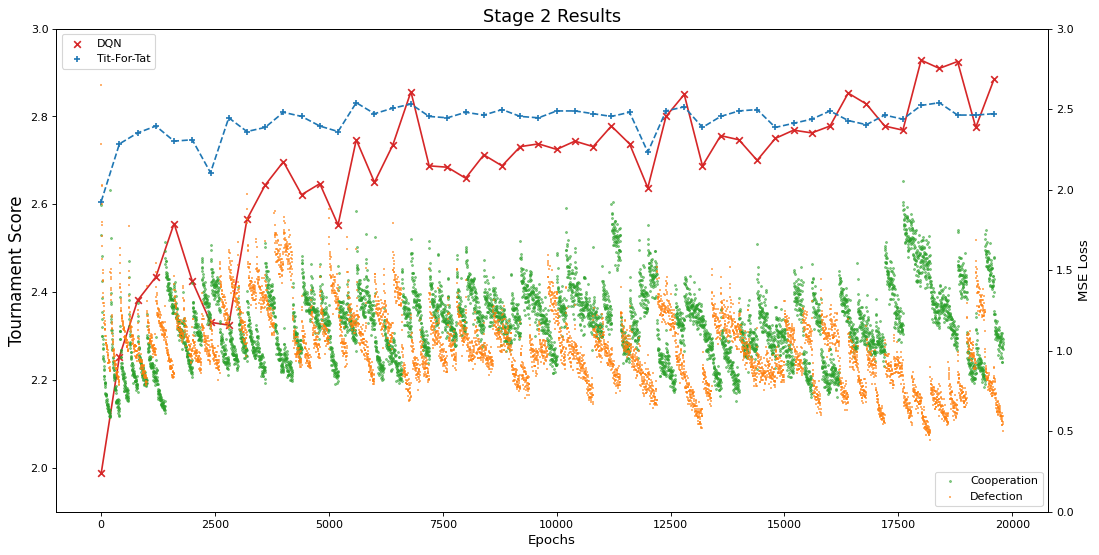

In [31]:
# visualizing the results

# we did collected more data than those demonstrated below
# but since our DQN did not converge to TFT I don't think the C_rate(s) are of any use...

# extracting score from DQN & TFT
d_score = pd.DataFrame([l.loc['DQN','Median_score'] for l in ls]).to_numpy().T[0]
t_score = pd.DataFrame([l.loc['Tit For Tat','Median_score'] for l in ls]).to_numpy().T[0]

fig, ax1 = plt.subplots(figsize=(16, 8), dpi=80)
ax2 = ax1.twinx()

# score
x_axis = range(0,20000,400)
ax1.scatter(x_axis, d_score, c='tab:red', marker='x', label='DQN')
ax1.scatter(x_axis, t_score, c='tab:blue', marker='+', label='Tit-For-Tat')
ax1.plot(x_axis, d_score, c='tab:red')
ax1.plot(x_axis, t_score, '--', c='tab:blue')
ax1.set_ylim([1.9, 3.0])

# loss
ax2.scatter(*zip(*[(i[0], i[1][0]) for i in p1.network.loss_ls[::3]]), c='tab:green', marker='x', label='Cooperation', alpha=.6, s=3)
ax2.scatter(*zip(*[(i[0], i[1][1]) for i in p1.network.loss_ls[::3]]), c='tab:orange', marker='+', label='Defection', alpha=.6, s=3)
ax2.set_ylim([0.0, 3.0])

ax1.legend(loc='upper left')
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Tournament Score', fontsize=15)
ax1.set_title('Stage 2 Results', fontsize=16)

ax2.legend(loc='lower right')
ax2.set_ylabel('MSE Loss', fontsize=12)

plt.show()

In [12]:
p1.set_greedy(0)
p1.network.verbosity = False

In [13]:
print("Prober")
play(p1, axl.RemorsefulProber(0.2));

print("\nTFT")
play(p1, axl.TitForTat());

print("\nAlternator")
play(p1, axl.Alternator());  # <- failed to match against such simple strategy

# sadly our DQN didn't generalize
# it was able to find the global optimum for this particular tournament (by differentiating its opponent then exploit)
# but failed to do so for the entire IPD game (by converging to TFT)

Prober
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (0, 5), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0), (0, 5), (1, 1)]
Player 1 score = 48
Player 2 score = 58

TFT
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0), (0, 5), (3, 3), (3, 3), (5, 0), (0, 5), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 60
Player 2 score = 55

Alternator
[(3, 3), (0, 5), (5, 0), (0, 5), (3, 3), (0, 5), (3, 3), (1, 1), (3, 3), (1, 1), (3, 3), (0, 5), (5, 0), (0, 5), (3, 3), (0, 5), (3, 3), (0, 5), (3, 3), (1, 1)]
Player 1 score = 37
Player 2 score = 62


In [47]:
# and this is how TFT react to alternator
# 11 score higher than our tournament champion
play(axl.TitForTat(), axl.Alternator());

[(3, 3), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5), (5, 0), (0, 5)]
Player 1 score = 48
Player 2 score = 53


In [ ]:
# => continue exploration on stage 3

# Extra training
since tournament score is still increasing

In [13]:
with open("data/s2/backup/p1_98.pkl", "rb") as file:
    p1 = dill.load(file)

with open("data/s2/backup/tn_results.pkl", "rb") as file:
    ls = dill.load(file)
    
param = {"lr": 1e-6, 'batch': 128, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': ('l2', 1e-2), "loss_fn":"mse"}

In [ ]:
# time to take a nap
loss_ls = []
epoch_ls = []
for i in range(100, 200):
    
    start = time()
    p1.train(200, param)
    
    train_against(p1, players)
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # test DQN in tournament
    if i % 2 == 0:
        loss_ls.append(np.sum(p1.network.loss))
        with p1:
            p1.network.verbosity = False
            tournament = Tournament([p1, *players], game=GAME, turns=GAME_LEN)
            results = tournament.play()
            summary = pd.DataFrame(map(list, results.summarise()), columns=headers).set_index('Name')
            ls.append(summary)
            epoch_ls.append(p1.network.epoch)
            
        print(summary.loc['DQN', ['Rank', 'Median_score']])
        
        # backing up
        with open('data/s2/tn_results2.pkl', "wb") as file:
            dill.dump(ls, file)

        with open(f'data/s2/p1_{i}.pkl', "wb") as file:
            dill.dump(p1, file)

loss: [1.128 0.6  ],            time: +130.57 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.64it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [1.309 0.843],            time: +115.85 sec
loss: [1.436 0.616],            time: +118.77 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 151.52it/s]


Rank           1.00
Median_score   2.80
Name: DQN, dtype: float64
loss: [1.246 0.878],            time: +114.33 sec
loss: [1.12  0.931],            time: +114.49 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.64it/s]


Rank           0.00
Median_score   2.94
Name: DQN, dtype: float64
loss: [0.86 0.86],            time: +117.96 sec
loss: [1.087 0.683],            time: +122.08 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 151.49it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [1.425 0.64 ],            time: +120.88 sec
loss: [1.46  0.691],            time: +121.36 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 155.28it/s]


Rank           0.00
Median_score   2.84
Name: DQN, dtype: float64
loss: [1.653 0.651],            time: +120.96 sec
loss: [1.034 0.885],            time: +121.26 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 159.20it/s]


Rank           0.00
Median_score   2.81
Name: DQN, dtype: float64
loss: [0.913 1.12 ],            time: +121.52 sec
loss: [1.129 0.869],            time: +121.16 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 163.37it/s]


Rank           1.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [0.903 1.069],            time: +121.00 sec
loss: [1.131 0.636],            time: +121.24 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 167.79it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [1.475 0.639],            time: +121.34 sec
loss: [1.228 0.671],            time: +121.59 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 161.25it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [1.042 0.539],            time: +121.54 sec
loss: [0.975 1.124],            time: +121.22 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 165.57it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [0.826 1.116],            time: +121.29 sec
loss: [1.133 0.788],            time: +121.08 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.67it/s]


Rank           1.00
Median_score   2.75
Name: DQN, dtype: float64
loss: [1.31  0.903],            time: +120.84 sec
loss: [1.089 0.758],            time: +120.92 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 157.20it/s]


Rank           0.00
Median_score   2.95
Name: DQN, dtype: float64
loss: [1.268 0.581],            time: +120.67 sec
loss: [1.335 0.706],            time: +121.45 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 159.22it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [1.061 0.516],            time: +121.32 sec
loss: [1.019 0.64 ],            time: +121.32 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 152.44it/s]


Rank           1.00
Median_score   2.74
Name: DQN, dtype: float64
loss: [1.114 1.196],            time: +121.44 sec
loss: [1.547 0.798],            time: +121.56 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 161.26it/s]


Rank           1.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [1.177 0.929],            time: +121.12 sec
loss: [0.936 1.261],            time: +121.52 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 167.79it/s]


Rank           0.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [0.895 1.199],            time: +121.08 sec
loss: [1.413 0.903],            time: +121.69 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 165.56it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [1.287 0.802],            time: +121.25 sec
loss: [1.404 0.617],            time: +121.37 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 163.37it/s]


Rank           0.00
Median_score   2.95
Name: DQN, dtype: float64
loss: [1.295 0.681],            time: +121.09 sec
loss: [0.787 1.16 ],            time: +120.43 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 168.87it/s]


Rank           1.00
Median_score   2.78
Name: DQN, dtype: float64
loss: [0.853 1.314],            time: +120.36 sec
loss: [0.891 0.802],            time: +120.81 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 171.20it/s]


Rank           0.00
Median_score   2.90
Name: DQN, dtype: float64
loss: [0.875 0.561],            time: +123.70 sec
loss: [1.021 0.644],            time: +120.39 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 164.41it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [0.896 0.572],            time: +120.91 sec
loss: [1.004 0.747],            time: +121.18 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.63it/s]


Rank           0.00
Median_score   2.91
Name: DQN, dtype: float64
loss: [0.84  0.686],            time: +120.90 sec
loss: [1.061 0.609],            time: +121.74 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 160.23it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [1.104 0.768],            time: +120.58 sec
loss: [1.134 0.817],            time: +119.87 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.67it/s]


Rank           0.00
Median_score   2.95
Name: DQN, dtype: float64
loss: [1.323 0.603],            time: +121.07 sec
loss: [0.913 1.   ],            time: +120.95 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 162.30it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [0.893 0.824],            time: +121.05 sec
loss: [1.169 0.742],            time: +120.52 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 179.82it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [0.863 0.95 ],            time: +121.13 sec
loss: [1.045 0.758],            time: +120.92 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 174.78it/s]


Rank           0.00
Median_score   2.95
Name: DQN, dtype: float64
loss: [1.085 0.696],            time: +120.75 sec
loss: [1.18  0.654],            time: +120.47 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 183.79it/s]


Rank           0.00
Median_score   2.95
Name: DQN, dtype: float64
loss: [1.032 0.599],            time: +120.77 sec
loss: [1.289 0.654],            time: +121.45 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 150.60it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [1.015 0.872],            time: +120.55 sec
loss: [1.095 0.678],            time: +121.01 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 177.27it/s]


Rank           0.00
Median_score   2.92
Name: DQN, dtype: float64
loss: [1.246 0.639],            time: +120.60 sec
loss: [1.079 0.617],            time: +120.74 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 166.67it/s]


Rank           0.00
Median_score   2.91
Name: DQN, dtype: float64
loss: [0.967 0.626],            time: +121.05 sec
loss: [0.999 0.895],            time: +120.88 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 182.48it/s]


Rank           1.00
Median_score   2.81
Name: DQN, dtype: float64
loss: [0.851 1.035],            time: +121.01 sec
loss: [1.158 0.861],            time: +121.15 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 179.86it/s]


Rank           0.00
Median_score   2.82
Name: DQN, dtype: float64
loss: [1.171 0.864],            time: +121.87 sec
loss: [1.328 0.63 ],            time: +120.62 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 177.31it/s]


Rank           0.00
Median_score   2.93
Name: DQN, dtype: float64
loss: [1.277 0.672],            time: +121.09 sec
loss: [1.177 0.712],            time: +121.26 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 168.88it/s]


Rank           0.00
Median_score   2.80
Name: DQN, dtype: float64
loss: [0.75  1.054],            time: +120.76 sec
loss: [0.861 1.1  ],            time: +121.28 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 171.14it/s]


Rank           0.00
Median_score   2.91
Name: DQN, dtype: float64
loss: [0.965 0.742],            time: +121.04 sec
loss: [1.197 0.787],            time: +120.58 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 177.30it/s]


Rank           0.00
Median_score   2.93
Name: DQN, dtype: float64
loss: [1.249 0.656],            time: +121.11 sec
loss: [1.008 0.654],            time: +120.77 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 155.28it/s]


Rank           1.00
Median_score   2.81
Name: DQN, dtype: float64
loss: [1.166 0.895],            time: +121.16 sec
loss: [1.182 1.078],            time: +121.57 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 179.82it/s]


Rank           0.00
Median_score   2.79
Name: DQN, dtype: float64
loss: [0.993 1.068],            time: +120.63 sec
loss: [0.969 0.738],            time: +120.70 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 178.57it/s]


Rank           1.00
Median_score   2.83
Name: DQN, dtype: float64
loss: [1.151 0.891],            time: +120.92 sec
loss: [0.926 0.744],            time: +122.74 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 130.19it/s]


Rank           0.00
Median_score   2.94
Name: DQN, dtype: float64
loss: [0.871 0.96 ],            time: +121.10 sec
loss: [0.82  0.659],            time: +120.71 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 173.57it/s]


Rank           0.00
Median_score   2.91
Name: DQN, dtype: float64
loss: [0.982 0.552],            time: +120.94 sec
loss: [1.049 0.755],            time: +120.68 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 181.17it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64
loss: [1.129 0.836],            time: +121.00 sec
loss: [1.17  1.109],            time: +123.80 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 182.38it/s]


Rank           0.00
Median_score   2.83
Name: DQN, dtype: float64
loss: [1.406 0.612],            time: +121.98 sec
loss: [1.124 0.647],            time: +122.77 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 182.42it/s]


Rank           0.00
Median_score   2.84
Name: DQN, dtype: float64
loss: [1.095 0.788],            time: +122.62 sec
loss: [1.153 0.675],            time: +119.16 sec


Analysing: 100%|██████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 125.47it/s]


Rank           1.00
Median_score   2.77
Name: DQN, dtype: float64


In [41]:
# results

with open("data/s2/backup/tn_results2.pkl", "rb") as file:
    ls = dill.load(file)
with open(f"data/s2/backup/p1_196.pkl", "rb") as file:
    p1 = dill.load(file)

In [42]:
pd.DataFrame([l.loc['DQN'] for l in ls], index=range(100))

,Rank,Median_score,Cooperation_rating,Wins,Initial_C_rate,CC_rate,CD_rate,DC_rate,DD_rate,CC_to_C_rate,CD_to_C_rate,DC_to_C_rate,DD_to_C_rate
0,8.00,1.99,0.04,8.00,0.00,0.02,0.03,0.24,0.71,0.00,0.00,0.15,0.15
1,7.00,2.25,0.48,5.00,0.00,0.09,0.38,0.36,0.16,0.38,0.48,0.67,0.58
2,6.00,2.38,0.47,5.00,0.00,0.13,0.34,0.36,0.16,0.41,0.22,0.67,0.99
3,4.00,2.43,0.49,4.00,0.00,0.17,0.32,0.35,0.16,0.56,0.37,0.66,0.92
4,2.00,2.56,0.58,4.50,1.00,0.37,0.21,0.26,0.16,0.79,0.30,0.46,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.00,2.78,0.37,5.00,0.00,0.25,0.12,0.35,0.28,0.79,0.49,0.74,0.18
96,0.00,2.94,0.76,5.00,1.00,0.66,0.10,0.18,0.07,0.85,0.83,0.97,0.22
97,0.00,2.81,0.37,5.00,0.00,0.27,0.10,0.34,0.29,0.86,0.51,0.51,0.49
98,0.00,3.00,0.84,7.00,1.00,0.80,0.04,0.11,0.05,0.95,0.67,0.95,0.32


In [43]:
d_score = pd.DataFrame([l.loc['DQN','Median_score'] for l in ls]).to_numpy().T[0]
t_score = pd.DataFrame([l.loc['Tit For Tat','Median_score'] for l in ls]).to_numpy().T[0]
d_score

array([1.988, 2.253, 2.381, 2.434, 2.556, 2.425, 2.331, 2.325, 2.566,
       2.644, 2.697, 2.622, 2.647, 2.553, 2.747, 2.65 , 2.734, 2.856,
       2.688, 2.684, 2.659, 2.712, 2.688, 2.731, 2.737, 2.725, 2.744,
       2.731, 2.778, 2.737, 2.638, 2.8  , 2.85 , 2.688, 2.756, 2.747,
       2.7  , 2.75 , 2.769, 2.763, 2.778, 2.853, 2.828, 2.778, 2.769,
       2.928, 2.909, 2.925, 2.775, 2.884, 2.759, 2.806, 2.781, 2.862,
       2.812, 2.8  , 2.731, 2.925, 2.759, 2.747, 2.919, 2.781, 2.919,
       2.919, 2.956, 2.819, 2.781, 2.775, 2.737, 2.753, 2.941, 2.95 ,
       2.875, 2.931, 2.75 , 2.762, 2.819, 2.931, 2.747, 2.725, 2.9  ,
       2.819, 2.931, 2.788, 2.925, 2.922, 2.794, 2.791, 2.784, 2.809,
       2.903, 2.656, 2.791, 2.931, 2.95 , 2.781, 2.944, 2.812, 3.   ,
       2.881])

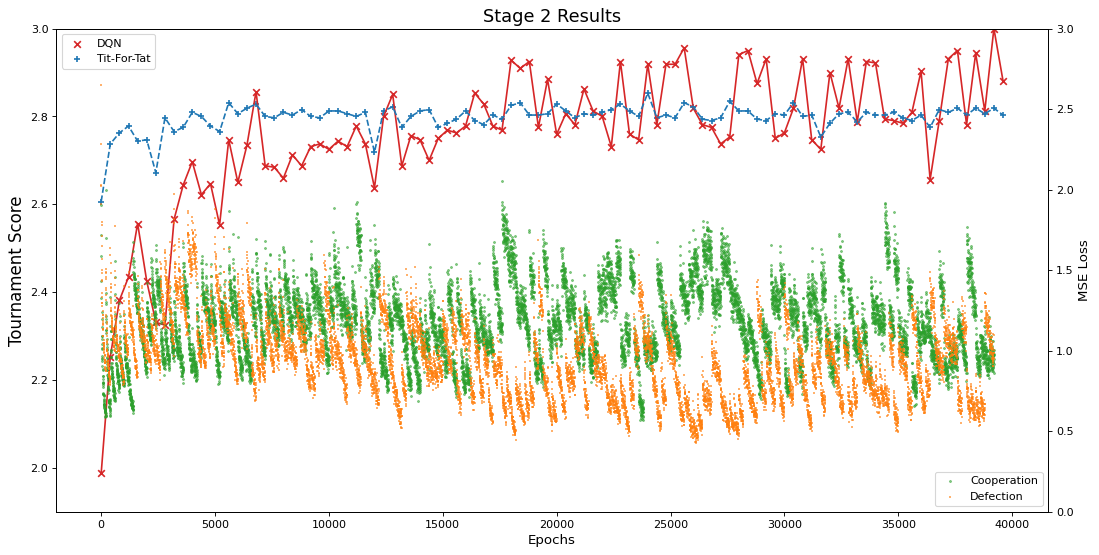

In [45]:
fig, ax1 = plt.subplots(figsize=(16, 8), dpi=80)
ax2 = ax1.twinx()

x_axis = range(0,40000,400)
ax1.scatter(x_axis, d_score, c='tab:red', marker='x', label='DQN')
ax1.scatter(x_axis, t_score, c='tab:blue', marker='+', label='Tit-For-Tat')
ax1.plot(x_axis, d_score, c='tab:red')
ax1.plot(x_axis, t_score, '--', c='tab:blue')
ax1.set_ylim([1.9, 3.0])

ax2.scatter(*zip(*[(i[0], i[1][0]) for i in p1.network.loss_ls[::3]]), c='tab:green', marker='x', label='Cooperation', alpha=.6, s=3)
ax2.scatter(*zip(*[(i[0], i[1][1]) for i in p1.network.loss_ls[::3]]), c='tab:orange', marker='+', label='Defection', alpha=.6, s=3)
ax2.set_ylim([0.0, 3.0])

ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Tournament Score', fontsize=15)
ax1.legend(loc='upper left')
ax1.set_title('Stage 2 Results', fontsize=16)

ax2.set_ylabel('MSE Loss', fontsize=12)
ax2.legend(loc='lower right')

plt.show()

# it does seem the learning is capped at ~2.9
# this is already a outstanding result
# but,

In [46]:
# testing the best one we got (median score = 3.0)
p1.set_greedy(0.0)
play(p1, axl.Alternator())

# do show some capability of retaliation in the first few turns
# but somehow failed to do so in the second half
# I don't think giving more epochs will fix this
# lets jump to stage 3...

[(3, 3), (0, 5), (5, 0), (0, 5), (3, 3), (0, 5), (5, 0), (0, 5), (3, 3), (0, 5), (3, 3), (0, 5), (3, 3), (0, 5), (3, 3), (0, 5), (3, 3), (0, 5), (3, 3), (1, 1)]
Player 1 score = 35
Player 2 score = 70
